In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath(".")), ""))
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
from src import ElmanRNN, Adam

%matplotlib inline
plt.rcParams.update({"figure.dpi": 120, "font.size": 9})

In [2]:
def make_sequences(parametric_fn, n_seqs, seq_len, dt, rng):
    """Next-step prediction data from a parametric curve.

    parametric_fn(theta) -> (x_array, y_array)
    Returns x, y each of shape (seq_len, n_seqs, 2).
    """
    phases = rng.uniform(0, 2 * np.pi, n_seqs)
    t = np.arange(seq_len + 1) * dt
    trajs = []
    for phi in phases:
        theta = phi + t
        xy = np.column_stack(parametric_fn(theta))  # (seq_len+1, 2)
        trajs.append(xy)
    data = np.stack(trajs, axis=1)  # (seq_len+1, n_seqs, 2)
    return data[:-1].copy(), data[1:].copy()


# Parametric curves
def circle_curve(theta, r=1.0, cx=0.0, cy=0.0):
    return r * np.cos(theta) + cx, r * np.sin(theta) + cy

def figure8_curve(theta):
    return np.sin(theta), np.sin(theta) * np.cos(theta)


def train(model, opt, x, y, batch_indices, n_epochs, print_every=500):
    losses = []
    for ep in range(1, n_epochs + 1):
        result = model.forward(x, y, batch_indices=batch_indices)
        grads, dH0 = model.backward(result.cache)
        model.params, new_H0, gnorm = opt.step(
            model.params, grads, dH0, model.H0_params, batch_indices
        )
        if new_H0 is not None:
            model.H0_params = new_H0
        losses.append(result.loss)
        if ep % print_every == 0 or ep == 1:
            print(f"  epoch {ep:5d}  loss {result.loss:.6f}  |g| {gnorm:.4f}")
    return losses


def generate(model, x0, n_steps, seq_idx=0):
    """Rollout from x0 using learned H0[seq_idx]."""
    x_t = x0.reshape(1, 1, -1)
    if model.H0_params is not None:
        h = model.H0_params[seq_idx : seq_idx + 1].copy()
    else:
        h = np.zeros((1, model.params.hidden_size), dtype=np.float64)
    traj = [x0.copy()]
    for _ in range(n_steps):
        res = model.forward(x_t, h0=h)
        traj.append(res.out[0, 0].copy())
        x_t = res.out.copy()
        h = res.h_last
    return np.array(traj)


def plot_with_arrows(ax, trajs, title="", every=3, labels=None):
    """2-D trajectories with quiver arrows showing direction."""
    cmap = plt.cm.tab10.colors
    for i, traj in enumerate(trajs):
        c = cmap[i % 10]
        lbl = labels[i] if labels else None
        ax.plot(traj[:, 0], traj[:, 1], "-", color=c, lw=1.2, alpha=0.7, label=lbl)
        idx = np.arange(0, len(traj) - 1, every)
        dx = traj[idx + 1, 0] - traj[idx, 0]
        dy = traj[idx + 1, 1] - traj[idx, 1]
        ax.quiver(
            traj[idx, 0], traj[idx, 1], dx, dy,
            color=c, angles="xy", scale_units="xy", scale=1,
            width=0.006, headwidth=3.5, zorder=3,
        )
    ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
    if labels:
        ax.legend(fontsize=8)

In [3]:
rng = np.random.default_rng(42)

T, B = 30, 16
dt = 2 * np.pi / 30

## Experiment 1 — Circle

16 training sequences of 30 steps each, **random starting phases** so the
network is forced to learn the rotational dynamics rather than memorise one
particular initial condition.  Evaluation: 3 full cycles (90 steps).

Training on circle (16 seqs × 30 steps, random phases)…
  epoch     1  loss 0.505692  |g| 0.1418
  epoch   500  loss 0.006972  |g| 0.0161
  epoch  1000  loss 0.004348  |g| 0.0091
  epoch  1500  loss 0.002715  |g| 0.0067
  epoch  2000  loss 0.001436  |g| 0.0046
  epoch  2500  loss 0.000717  |g| 0.0028
  epoch  3000  loss 0.000364  |g| 0.0017


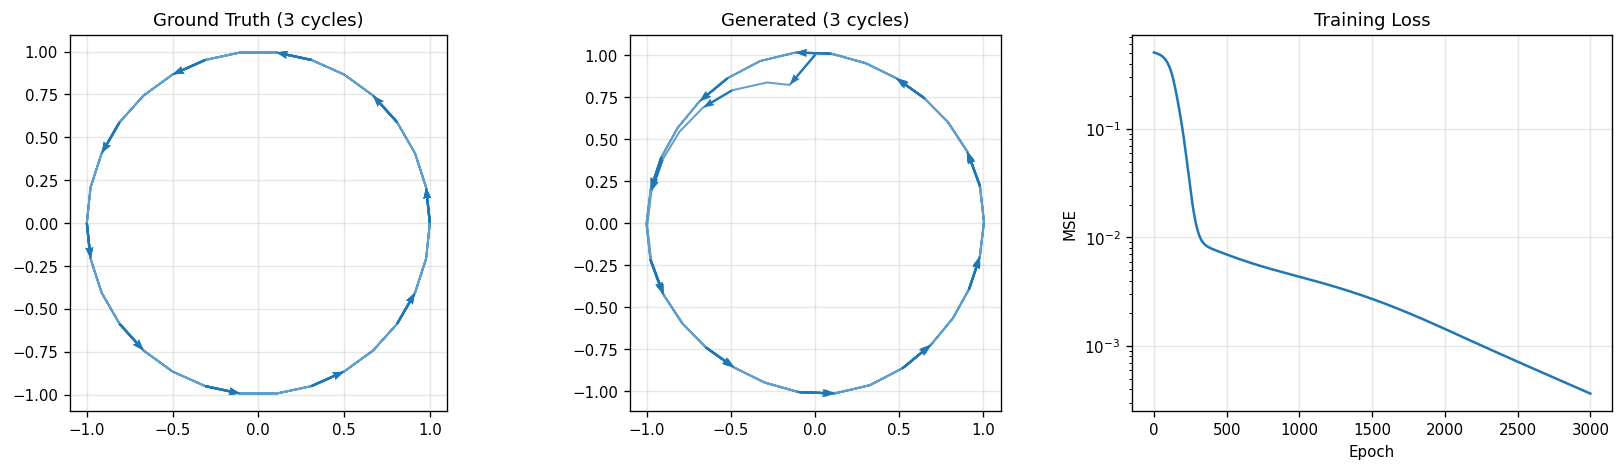

In [10]:
x_train, y_train = make_sequences(circle_curve, B, T, dt, rng)
batch_indices = np.zeros(B, dtype=np.int64)

model_c = ElmanRNN(2, 4, 2, num_sequences=1, activation="tanh",
                   weight_scale=0.1, rng=0)
opt_c = Adam(lr=1e-3, clip_norm=1.0)

print("Training on circle (16 seqs × 30 steps, random phases)…")
losses_c = train(model_c, opt_c, x_train, y_train, batch_indices, n_epochs=3000)

# Generate 3 full cycles autoregressively
pred_c = generate(model_c, np.array([0.0, 1.0]), n_steps=90)
gt_theta = np.linspace(0, 6 * np.pi, 91)
gt_c = np.column_stack([np.cos(gt_theta), np.sin(gt_theta)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_c], title="Ground Truth (3 cycles)")
plot_with_arrows(axes[1], [pred_c], title="Generated (3 cycles)")
axes[2].semilogy(losses_c)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Experiment 2 — Figure-of-8 (Lissajous)

$x = \sin\theta,\; y = \sin\theta\cos\theta$.  Same setup: 16 random-phase
sequences, next-step prediction.

Training on figure-8 (16 seqs × 30 steps, random phases)…
  epoch     1  loss 0.384822  |g| 0.9561
  epoch   500  loss 0.002511  |g| 0.0052
  epoch  1000  loss 0.001132  |g| 0.0011
  epoch  1500  loss 0.000759  |g| 0.0008
  epoch  2000  loss 0.000543  |g| 0.0005
  epoch  2500  loss 0.000413  |g| 0.0004
  epoch  3000  loss 0.000315  |g| 0.0003


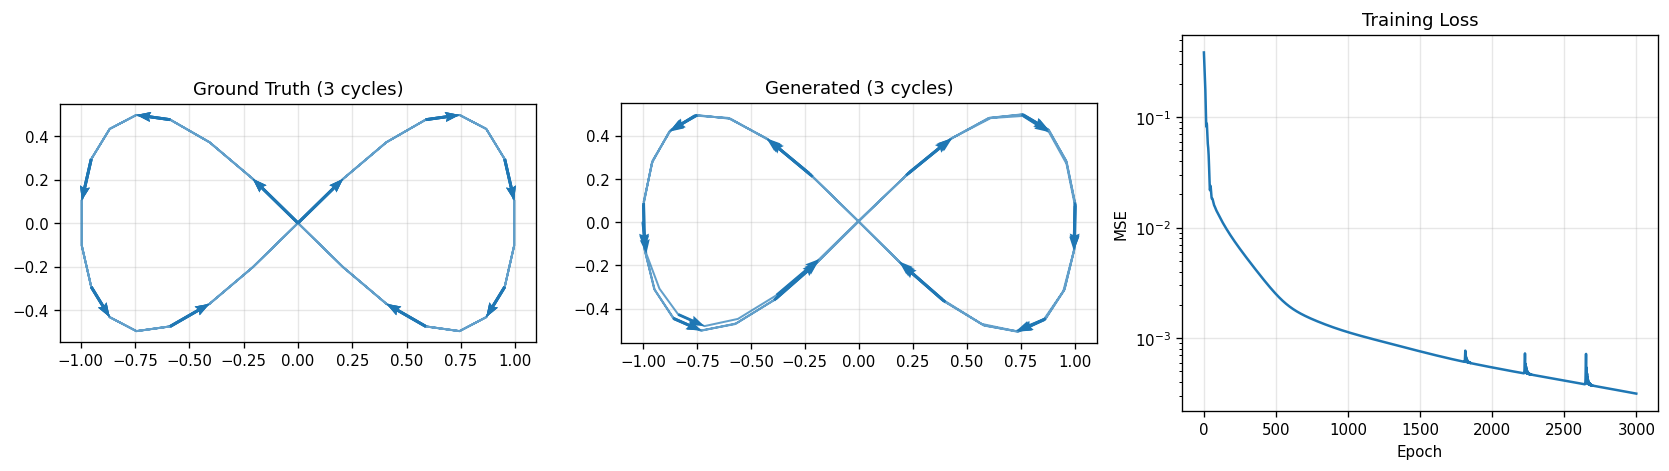

In [5]:
x_train8, y_train8 = make_sequences(figure8_curve, B, T, dt, rng)
batch_indices8 = np.zeros(B, dtype=np.int64)

model_8 = ElmanRNN(2, 64, 2, num_sequences=1, activation="tanh",
                   weight_scale=0.1, rng=1)
opt_8 = Adam(lr=1e-3, clip_norm=1.0)

print("Training on figure-8 (16 seqs × 30 steps, random phases)…")
losses_8 = train(model_8, opt_8, x_train8, y_train8, batch_indices8, n_epochs=3000)

# Generate 3 cycles
pred_8 = generate(model_8, np.array([-1.0, 0.0]), n_steps=90)
gt_theta8 = np.linspace(0, 6 * np.pi, 91)
gt_8 = np.column_stack([np.sin(gt_theta8), np.sin(gt_theta8) * np.cos(gt_theta8)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_8], title="Ground Truth (3 cycles)")
plot_with_arrows(axes[1], [pred_8], title="Generated (3 cycles)")
axes[2].semilogy(losses_8)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Experiment 3 — Two intersecting circles

Two circles with shifted centres share weights but get **separate learnable
$h_0$** vectors (`num_sequences=2`).  At the intersection the only thing
distinguishing the two dynamics is the latent initial state.

Training on two intersecting circles (2 × 12 seqs)…
  epoch     1  loss 0.738673  |g| 2.5228
  epoch   500  loss 0.001473  |g| 0.0061
  epoch  1000  loss 0.000168  |g| 0.0020
  epoch  1500  loss 0.000008  |g| 0.0010
  epoch  2000  loss 0.000003  |g| 0.0000
  epoch  2500  loss 0.000002  |g| 0.0000
  epoch  3000  loss 0.000002  |g| 0.0000
  epoch  3500  loss 0.000002  |g| 0.0027
  epoch  4000  loss 0.000001  |g| 0.0017


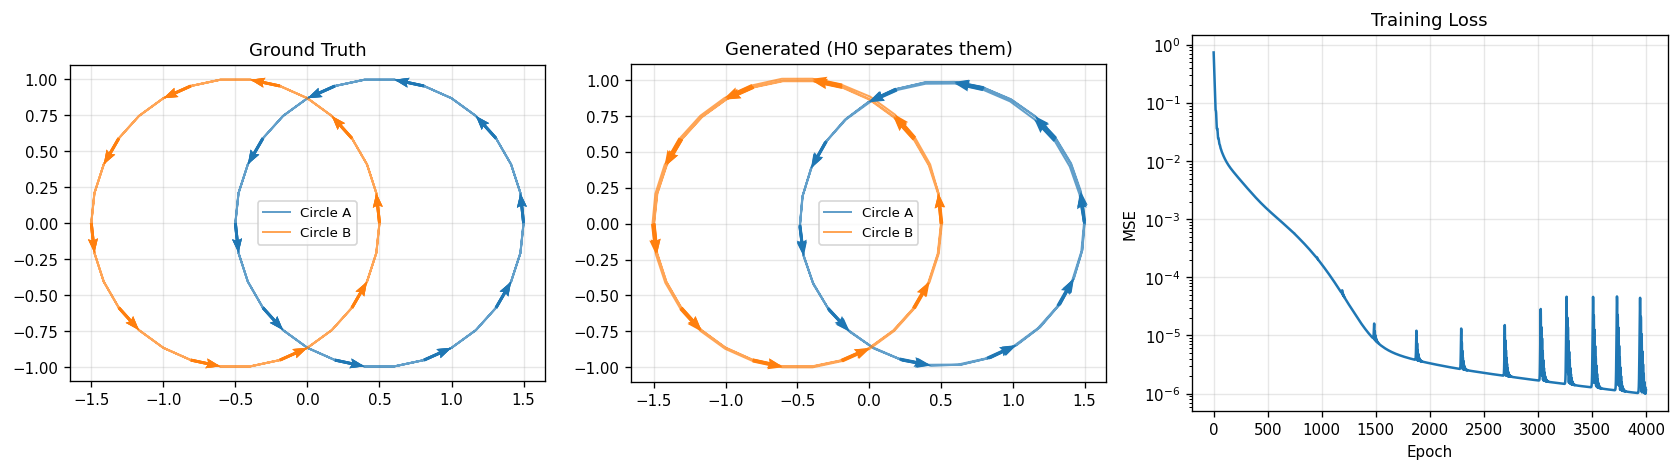

In [6]:
T, B_each = 30, 12
dt = 2 * np.pi / 30

# Circle A centred at (+0.5, 0), Circle B at (−0.5, 0)  →  they intersect
fn_a = lambda th: circle_curve(th, r=1.0, cx=0.5, cy=0.0)
fn_b = lambda th: circle_curve(th, r=1.0, cx=-0.5, cy=0.0)

xa, ya = make_sequences(fn_a, B_each, T, dt, rng)
xb, yb = make_sequences(fn_b, B_each, T, dt, rng)

x_train2 = np.concatenate([xa, xb], axis=1)   # (T, 2*B_each, 2)
y_train2 = np.concatenate([ya, yb], axis=1)
batch_indices2 = np.array([0] * B_each + [1] * B_each, dtype=np.int64)

model_2 = ElmanRNN(2, 64, 2, num_sequences=2, activation="tanh",
                   weight_scale=0.1, rng=2)
opt_2 = Adam(lr=1e-3, clip_norm=1.0)

print("Training on two intersecting circles (2 × 12 seqs)…")
losses_2 = train(model_2, opt_2, x_train2, y_train2, batch_indices2, n_epochs=4000)

# Generate 3 cycles for each circle
pred_a = generate(model_2, np.array([1.5, 0.0]), n_steps=90, seq_idx=0)
pred_b = generate(model_2, np.array([0.5, 0.0]), n_steps=90, seq_idx=1)

gt_theta2 = np.linspace(0, 6 * np.pi, 91)
gt_a = np.column_stack([np.cos(gt_theta2) + 0.5, np.sin(gt_theta2)])
gt_b = np.column_stack([np.cos(gt_theta2) - 0.5, np.sin(gt_theta2)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_a, gt_b], title="Ground Truth",
                 labels=["Circle A", "Circle B"])
plot_with_arrows(axes[1], [pred_a, pred_b], title="Generated (H0 separates them)",
                 labels=["Circle A", "Circle B"])
axes[2].semilogy(losses_2)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Training on two intersecting circles (2 × 12 seqs)…
  epoch     1  loss 23.815141  |g| 22.9465
  epoch   500  loss 0.006356  |g| 0.0219
  epoch  1000  loss 0.001155  |g| 0.0056
  epoch  1500  loss 0.000361  |g| 0.0028
  epoch  2000  loss 0.000147  |g| 0.0012
  epoch  2500  loss 0.000073  |g| 0.0006
  epoch  3000  loss 0.000048  |g| 0.0224
  epoch  3500  loss 0.000043  |g| 0.0462
  epoch  4000  loss 0.000028  |g| 0.0264
  epoch  4500  loss 0.000021  |g| 0.0194
  epoch  5000  loss 0.000016  |g| 0.0016
  epoch  5500  loss 0.000013  |g| 0.0002
  epoch  6000  loss 0.000024  |g| 0.0370
  epoch  6500  loss 0.000010  |g| 0.0004
  epoch  7000  loss 0.000009  |g| 0.0068
  epoch  7500  loss 0.000007  |g| 0.0009
  epoch  8000  loss 0.000007  |g| 0.0030


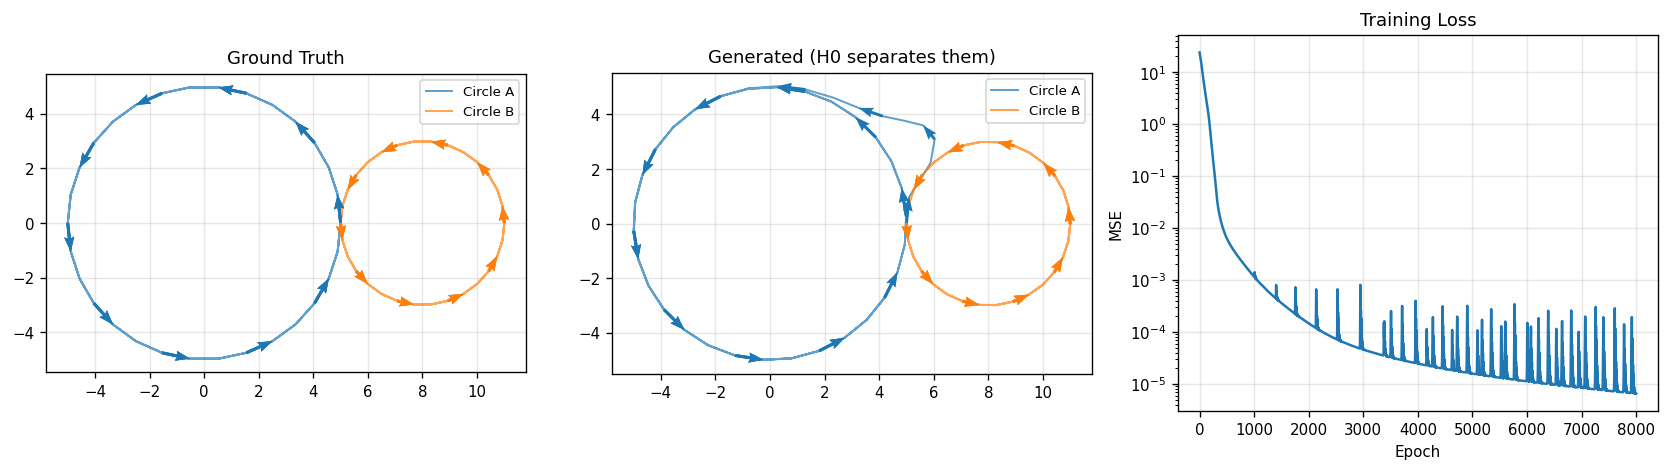

In [12]:
T, B_each = 30, 12
dt = 2 * np.pi / 30

fn_a = lambda th: circle_curve(th, r=5.0, cx=0.0, cy=0.0)
fn_b = lambda th: circle_curve(th, r=3.0, cx=8.0, cy=0.0)

xa, ya = make_sequences(fn_a, B_each, T, dt, rng)
xb, yb = make_sequences(fn_b, B_each, T, dt, rng)

x_train2 = np.concatenate([xa, xb], axis=1)   # (T, 2*B_each, 2)
y_train2 = np.concatenate([ya, yb], axis=1)
batch_indices2 = np.array([0] * B_each + [1] * B_each, dtype=np.int64)

model_2 = ElmanRNN(2, 32, 2, num_sequences=2, activation="tanh",
                   weight_scale=0.1, rng=2)
opt_2 = Adam(lr=1e-3, clip_norm=1.0)

print("Training on two intersecting circles (2 × 12 seqs)…")
losses_2 = train(model_2, opt_2, x_train2, y_train2, batch_indices2, n_epochs=8000)

# Generate 3 cycles for each circle
pred_a = generate(model_2, np.array([5.0, 0.0]), n_steps=90, seq_idx=0)
pred_b = generate(model_2, np.array([5.0, 0.0]), n_steps=90, seq_idx=1)

gt_theta2 = np.linspace(0, 6 * np.pi, 91)
gt_a = np.column_stack(circle_curve(gt_theta2, r=5.0, cx=0.0, cy=0.0))
gt_b = np.column_stack(circle_curve(gt_theta2, r=3.0, cx=8.0, cy=0.0))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_a, gt_b], title="Ground Truth",
                 labels=["Circle A", "Circle B"])
plot_with_arrows(axes[1], [pred_a, pred_b], title="Generated (H0 separates them)",
                 labels=["Circle A", "Circle B"])
axes[2].semilogy(losses_2)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

  epoch     1  loss 23.520564  |g| 23.1329
  epoch   500  loss 0.012900  |g| 0.1209
  epoch  1000  loss 0.001569  |g| 0.0064
  epoch  1500  loss 0.000495  |g| 0.0025
  epoch  2000  loss 0.000257  |g| 0.0940
  epoch  2500  loss 0.000140  |g| 0.0013
  epoch  3000  loss 0.000092  |g| 0.0010
  epoch  3500  loss 0.000066  |g| 0.0006
  epoch  4000  loss 0.000050  |g| 0.0161
  epoch  4500  loss 0.000040  |g| 0.0196
  epoch  5000  loss 0.000057  |g| 0.0979
  epoch  5500  loss 0.000027  |g| 0.0174
  epoch  6000  loss 0.000027  |g| 0.0364


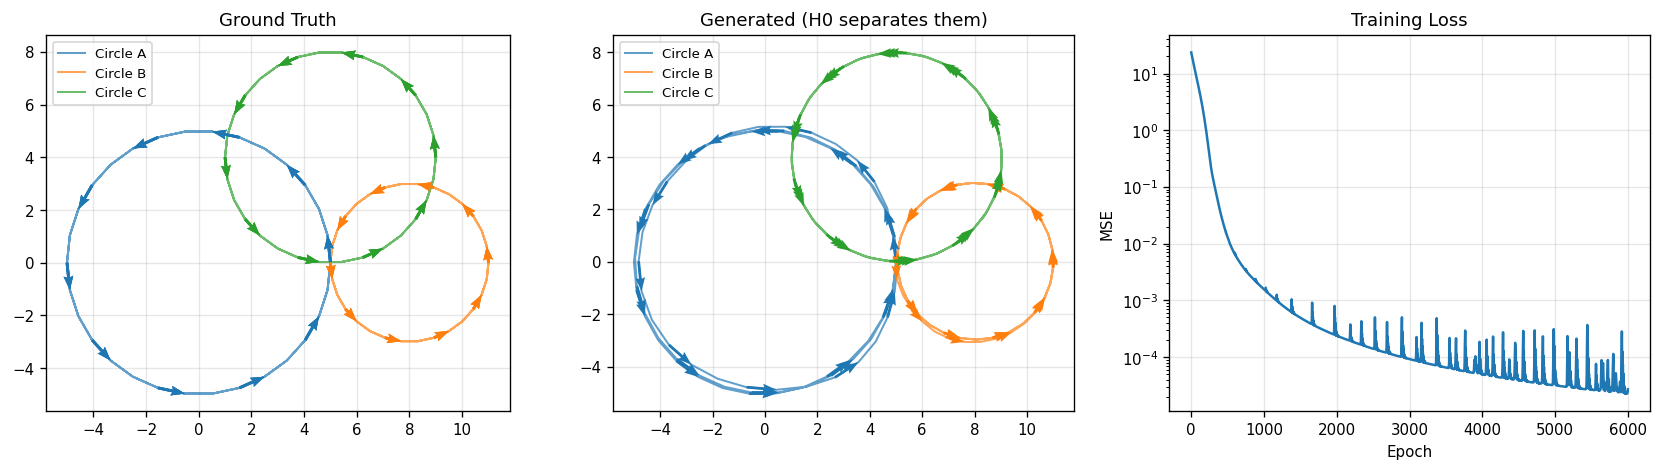

In [8]:
T, B_each = 30, 12
dt = 2 * np.pi / 30

fn_a = lambda th: circle_curve(th, r=5.0, cx=0.0, cy=0.0)
fn_b = lambda th: circle_curve(th, r=3.0, cx=8.0, cy=0.0)
fn_c = lambda th: circle_curve(th, r=4.0, cx=5.0, cy=4.0)

xa, ya = make_sequences(fn_a, B_each, T, dt, rng)
xb, yb = make_sequences(fn_b, B_each, T, dt, rng)
xc, yc = make_sequences(fn_c, B_each, T, dt, rng)

x_train = np.concatenate([xa, xb, xc], axis=1)
y_train = np.concatenate([ya, yb, yc], axis=1)
batch_indices = np.array([0] * B_each + [1] * B_each + [2] * B_each, dtype=np.int64)

model = ElmanRNN(2, 32, 2, num_sequences=3, activation="tanh",
                   weight_scale=0.1, rng=rng)
opt = Adam(lr=1e-3, clip_norm=1.0)

losses = train(model, opt, x_train, y_train, batch_indices, n_epochs=6000)

pred_a = generate(model, np.array([5.0, 0.0]), n_steps=90, seq_idx=0)
pred_b = generate(model, np.array([5.0, 0.0]), n_steps=90, seq_idx=1)
pred_c = generate(model, np.array([5.0, 0.0]), n_steps=90, seq_idx=2)

gt_theta = np.linspace(0, 6 * np.pi, 91)
gt_a = np.column_stack(circle_curve(gt_theta, r=5.0, cx=0.0, cy=0.0))
gt_b = np.column_stack(circle_curve(gt_theta, r=3.0, cx=8.0, cy=0.0))
gt_c = np.column_stack(circle_curve(gt_theta, r=4.0, cx=5.0, cy=4.0))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot_with_arrows(axes[0], [gt_a, gt_b, gt_c], title="Ground Truth",
                 labels=["Circle A", "Circle B", "Circle C"])
plot_with_arrows(axes[1], [pred_a, pred_b, pred_c], title="Generated (H0 separates them)",
                 labels=["Circle A", "Circle B", "Circle C"])
axes[2].semilogy(losses)
axes[2].set(title="Training Loss", xlabel="Epoch", ylabel="MSE")
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()